## Import packages

In [3]:
%matplotlib inline
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from CFModel import CFModel

/Users/joujun/.pyenv/versions/2.7.10/envs/please_my_fridge/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define constants

In [2]:
RATINGS_CSV_FILE = './input/rating_result.csv'
MODEL_WEIGHTS_FILE = 'recipe_weights.h5'
K_FACTORS = 120
RNG_SEED = 144653

## Load Recipe data

In [3]:
ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep=',', 
                      encoding='utf-8', 
                      usecols=['id','userid', 'recipeid', 'rating'])
max_userid = ratings['userid'].max() + 1
max_recipeid = ratings['recipeid'].max() + 1
print(len(ratings), 'ratings loaded.')

(1048575, 'ratings loaded.')


## Create training set

In [4]:
shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)
Users = shuffled_ratings['userid'].values
print('Users:', Users, ', shape =', Users.shape)
Recipe = shuffled_ratings['recipeid'].values
print('Recipes:', Recipe, ', shape =', Recipe.shape)
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

('Users:', array([ 3579, 10010,  4542, ..., 11751,  6257,  8880]), ', shape =', (1048575,))
('Recipes:', array([1952, 1112, 1449, ..., 2014,  661, 1691]), ', shape =', (1048575,))
('Ratings:', array([5, 5, 4, ..., 3, 5, 4]), ', shape =', (1048575,))


## Define model

In [5]:
model = CFModel(max_userid, max_recipeid, K_FACTORS)
model.compile(loss='mse', optimizer='adamax')

CFModel.py:25: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  self.add(Merge([P, Q], mode='dot', dot_axes=1))


## Train model

In [7]:
callbacks = [EarlyStopping('val_loss', patience=2),
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
history = model.fit([Users, Recipe], Ratings, nb_epoch=30, validation_split=.1, verbose=1, callbacks=callbacks)

Train on 943717 samples, validate on 104858 samples
Epoch 1/10
943717/943717 [==============================] - 40306s 43ms/step - loss: 1.3052 - val_loss: 1.2088
Epoch 2/10
943717/943717 [==============================] - 10297s 11ms/step - loss: 1.1187 - val_loss: 1.1090
Epoch 3/10
943717/943717 [==============================] - 717s 759us/step - loss: 1.0548 - val_loss: 1.0726
Epoch 4/10
943717/943717 [==============================] - 768s 813us/step - loss: 1.0242 - val_loss: 1.0520
Epoch 5/10
943717/943717 [==============================] - 748s 792us/step - loss: 1.0041 - val_loss: 1.0438
Epoch 6/10
943717/943717 [==============================] - 818s 867us/step - loss: 0.9874 - val_loss: 1.0373
Epoch 7/10
943717/943717 [==============================] - 820s 869us/step - loss: 0.9703 - val_loss: 1.0350
Epoch 8/10
943717/943717 [==============================] - 761s 807us/step - loss: 0.9519 - val_loss: 1.0331
Epoch 9/10
943717/943717 [==============================] - 692s 7

In [7]:
[node.op.name for node in model.inputs]

[u'embedding_1_input', u'embedding_2_input']

In [8]:
[node.op.name for node in model.outputs]

[u'merge_1/ExpandDims']

In [ ]:
from keras import backend as K
from tensorflow.python.tools import optimize_for_inference_lib
from tensorflow.python.tools import freeze_graph

MODEL_NAME = "recipe.pb"
def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")

export_model(tf.train.Saver(), model, ['embedding_1_input', u'embedding_2_input'], "merge_1/ExpandDims")

## Plot training and validation RMSE

/Users/joujun/.pyenv/versions/2.7.10/envs/please_my_fridge/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


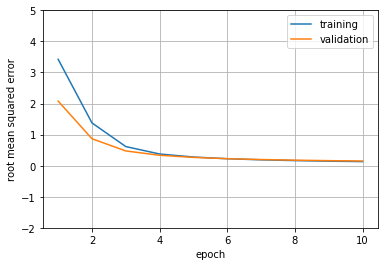

In [11]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = loss.ix[:,:].plot(x='epoch', grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([-2.0,5.0]);

In [67]:
crawling = {
    "noise":[0, 10, 20, 30],
    "DCG": [0.3296,0.3232,0.2980,0.2576],
    "NDCG": [0.7374,0.6949,0.5912,0.5878],
    "Precision": [0.5680,0.4270,0.3250,0.3010],
    "Average_Precision": [0.6602,0.5402,0.4211,0.4047],
    "RankDCG": [0.8322,0.5597,0.5677,0.3183]
}


movie = {
    "noise":[0, 10, 20, 30],
    "DCG": [0.2870,0.2841,0.2632,0.2049],
    "NDCG": [0.8478,0.8374,0.7817,0.7206],
    "Precision": [0.3230,0.3200,0.3040,0.2790],
    "Average_Precision": [0.3475,0.3186,0.2771,0.2233],
    "RankDCG": [0.6587,0.6479,0.5316,0.4269]
}

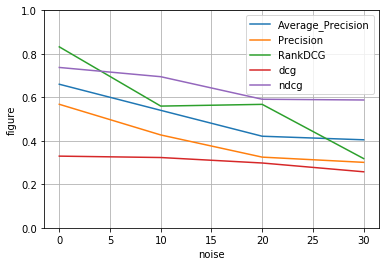

In [70]:
dcg = pd.DataFrame({'noise': [ i for i in crawling["noise"] ],
                     'dcg': [ dcg for dcg in crawling["DCG"] ],
                     'ndcg': [ dcg for dcg in crawling["NDCG"] ],
                    'Precision': [ dcg for dcg in crawling["Precision"] ],
                    'Average_Precision': [ dcg for dcg in crawling["Average_Precision"] ],
                    'RankDCG': [ dcg for dcg in crawling["RankDCG"] ],
                    
                    })
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = dcg.loc[:,:].plot(x='noise', grid=True)
ax.set_ylabel("figure")
ax.set_ylim([0.0,1.0]);

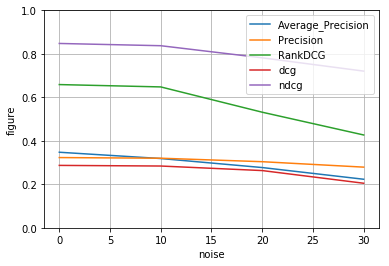

In [76]:
dcg = pd.DataFrame({'noise': [ i for i in movie["noise"] ],
                     'dcg': [ dcg for dcg in movie["DCG"] ],
                     'ndcg': [ dcg for dcg in movie["NDCG"] ],
                    'Precision': [ dcg for dcg in movie["Precision"] ],
                    'Average_Precision': [ dcg for dcg in movie["Average_Precision"] ],
                    'RankDCG': [ dcg for dcg in movie["RankDCG"] ],
                    
                    })
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = dcg.loc[:,:].plot(x='noise', grid=True)
ax.set_ylabel("figure")
ax.set_ylim([0.0,1.0]);

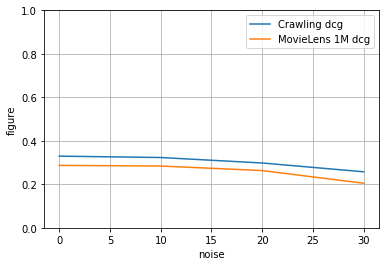

In [77]:
dcg = pd.DataFrame({'noise': [ i for i in crawling["noise"] ],
                     'Crawling dcg': [ dcg for dcg in crawling["DCG"] ],
                     'MovieLens 1M dcg': [ dcg for dcg in movie["DCG"] ],
                    })
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = dcg.loc[:,:].plot(x='noise', grid=True)
ax.set_ylabel("figure")
ax.set_ylim([0.0,1.0]);

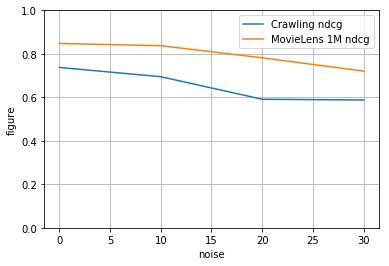

In [78]:
ndcg = pd.DataFrame({'noise': [ i for i in crawling["noise"] ],
                     'Crawling ndcg': [ ndcg for ndcg in crawling["NDCG"] ],
                     'MovieLens 1M ndcg': [ ndcg for ndcg in movie["NDCG"] ],
                    })
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = ndcg.loc[:,:].plot(x='noise', grid=True)
ax.set_ylabel("figure")
ax.set_ylim([0.0,1.0]);

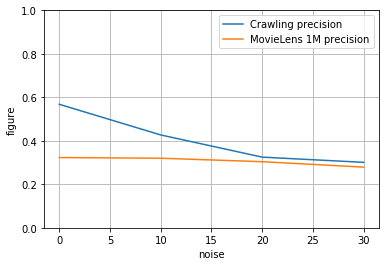

In [79]:
precision = pd.DataFrame({'noise': [ i for i in crawling["noise"] ],
                     'Crawling precision': [ pre for pre in crawling["Precision"] ],
                     'MovieLens 1M precision': [ pre for pre in movie["Precision"] ],
                     
                    })
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = precision.loc[:,:].plot(x='noise', grid=True)
ax.set_ylabel("figure")
ax.set_ylim([0.0,1.0]);

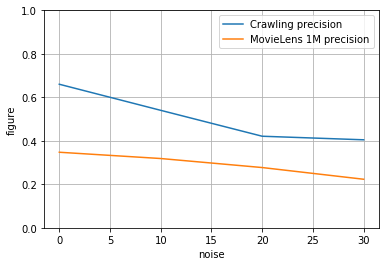

In [80]:
Average_Precision = pd.DataFrame({'noise': [ i for i in crawling["noise"] ],
                     'Crawling precision': [ pre for pre in crawling["Average_Precision"] ],
                     'MovieLens 1M precision': [ pre for pre in movie["Average_Precision"] ],
                     
                    })
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = Average_Precision.loc[:,:].plot(x='noise', grid=True)
ax.set_ylabel("figure")
ax.set_ylim([0.0,1.0]);

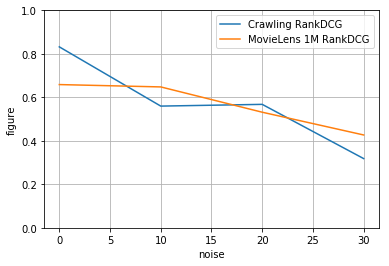

In [81]:
rankdcg = pd.DataFrame({'noise': [ i for i in crawling["noise"] ],
                     'Crawling RankDCG': [ rank for rank in crawling["RankDCG"] ],
                     'MovieLens 1M RankDCG': [ rank for rank in movie["RankDCG"] ],
                    })
#ax = loss.ix[:,:].plot(x='epoch', figsize={1,30}, grid=True)
ax = rankdcg.loc[:,:].plot(x='noise', grid=True)
ax.set_ylabel("figure")
ax.set_ylim([0.0,1.0]);